In [1]:
#create dataframe from mySQL server
import pymysql
import pandas as pd

conn=pymysql.connect(host='heatwave2multisource.multisource.prodvcn.oraclevcn.com',port=int(3306),user='phongthai',passwd='kg38IR^Ejer28e',db='phong_db')


In [549]:
df = pd.read_sql_query(
""" 
select * from phong_db.customers_multiple_merchants

""",conn)


In [550]:
df['Date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [551]:
from datetime import datetime, timedelta

start_date ='2022-06-01'
start_date=datetime.fromisoformat(start_date).date()
end_date = datetime.strftime(datetime.now() - timedelta(1), '%Y-%m-%d')
end_date=datetime.fromisoformat(end_date).date()

In [552]:
import datetime

df_append = []

while (start_date  <= end_date):

    df_s=df[df["Date"]== start_date.strftime('%Y-%m-%d')]
    df_before=df[df["Date"] < start_date.strftime('%Y-%m-%d')]    
    
    df1 = df_s[['fk_customer','id_merchant','merchant_name','Date']].drop_duplicates()
    df1.reset_index(drop=True)
    df1.rename(columns = {'merchant_name':'new'}, inplace = True)
    df_before = df_before[['fk_customer','id_merchant','merchant_name']].drop_duplicates()

    df2 = df_before.groupby(["fk_customer"])['merchant_name'].apply(list).reset_index(name='old')
    df3=df1.merge(df2,on=['fk_customer'], how='left')

    df3['new'] = df3['new'].astype(str)
    df3['old'] = df3['old'].astype(str)

    df3['old'] = df3["old"].str.replace("]","")
    df3['old'] = df3["old"].str.replace("[","")
    df3['old'] = df3["old"].str.replace("'","")

    df3['flag'] = df3.apply(lambda x: x.new in x.old, axis=1)   
    
    # filter the existing customers acquisition
    df4 = df3[df3['flag'] == False ]

    # counting the number of existing customer acquisition by merchant
    df5 = df4.groupby(['Date','new'])['fk_customer'].nunique().to_frame(name = 'count').reset_index()

    df_append.append(df5)
    
    
    start_date = start_date + datetime.timedelta(days=1) 

 

C:\Users\NGUYEN~1\AppData\Local\Temp/ipykernel_27836/2959973059.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3['old'] = df3["old"].str.replace("]","")
C:\Users\NGUYEN~1\AppData\Local\Temp/ipykernel_27836/2959973059.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3['old'] = df3["old"].str.replace("[","")


In [553]:
df6 = pd.concat(df_append)
df7 = df6.groupby('Date')['count'].sum()
df8 = pd.DataFrame(df7)

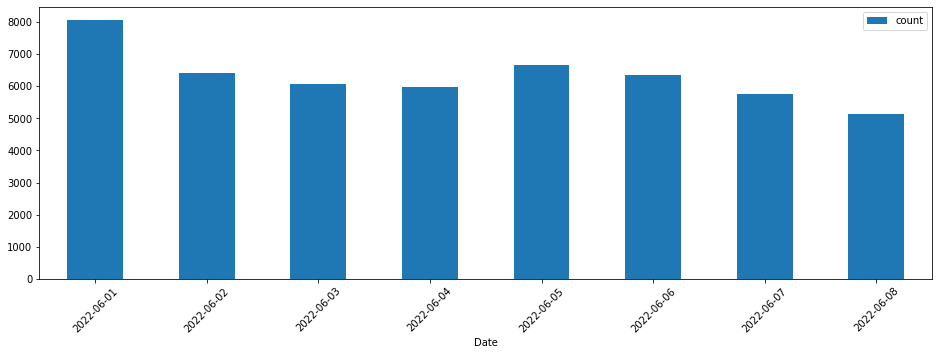

In [556]:
# plot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
df8.plot(kind="bar", figsize=(16,5), stacked=True, ax=ax)

# format xtick-labels with list comprehension
ax.set_xticklabels([x.strftime("%Y-%m-%d") for x in df8.index], rotation=45)
plt.show()